## Quantitative analysis using pynance and TaLib

#### Load and prepare the data.

In [20]:
import pandas as pd
import glob
import os

# Set the correct data path
data_folder = r'C:\Users\user\Downloads\yfinance_data\yfinance_data'
os.chdir(data_folder)  # Change working directory

# Load all datasets with validation
stocks = {}
for file in glob.glob('*_historical_data.csv'):
    try:
        # Extract ticker name (AAPL, AMZN, etc.)
        ticker = os.path.basename(file).split('_')[0].upper()
        
        # Load and validate data
        df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
        required_cols = {'Open', 'High', 'Low', 'Close', 'Volume'}
        if not required_cols.issubset(df.columns):
            print(f"Skipping {file}: Missing required columns")
            continue
            
        stocks[ticker] = df
        print(f"Loaded {ticker} ({len(df)} rows)")
        
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

# Final verification
if not stocks:
    print("No datasets loaded! Check:")
    print(f"- Folder contents: {os.listdir(data_folder)}")
    print("- File naming pattern: Should end with '_historical_data.csv'")
else:
    print(f"\n Successfully loaded {len(stocks)} stocks: {list(stocks.keys())}")
    print("\nSample data (AAPL):")
    display(stocks['AAPL'].head(2))

Loaded AAPL (10998 rows)
Loaded AMZN (6846 rows)
Loaded GOOG (5020 rows)
Loaded META (2926 rows)
Loaded MSFT (9672 rows)
Loaded NVDA (6421 rows)
Loaded TSLA (3545 rows)

 Successfully loaded 7 stocks: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

Sample data (AAPL):


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0


#### Technical Indicators (TA-Lib)

In [23]:
import talib
import numpy as np

def add_ta_indicators(df):
    """Add technical indicators to stock data"""
    # Moving Averages
    df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
    df['EMA_50'] = talib.EMA(df['Close'], timeperiod=50)
    
    # Momentum
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df['MACD'], df['MACD_Signal'], _ = talib.MACD(df['Close'])
    
    # Volatility
    df['ATR_14'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['Bollinger_Upper'], df['Bollinger_Middle'], df['Bollinger_Lower'] = talib.BBANDS(
        df['Close'], timeperiod=20)
    return df

# Apply to all stocks
stocks = {ticker: add_ta_indicators(df) for ticker, df in stocks.items()}

In [5]:
pip install pynance

  Using cached pandas_datareader-0.10.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.2 kB ? eta -:--:--
     ---------------------- ---------------- 61.4/108.2 kB 1.7 MB/s eta 0:00:01
     ----------------------------- --------- 81.9/108.2 kB 1.2 MB/s eta 0:00:01
     ----------------------------- --------- 81.9/108.2 kB 1.2 MB/s eta 0:00:01
     ------------------------------- ----- 92.2/108.2 kB 438.1 kB/s eta 0:00:01
     ---------------------------------- - 102.4/108.2 kB 454.0 kB/s eta 0:00:01
     ---------------------------------- - 102.4/108.2 kB 454.0 kB/s eta 0:00:01
     ---------------------------------- - 102.4/108.2 kB 454.0 kB/s eta 0:00:01
     ---------------------------------- - 102.4/108.2 kB 454.0 kB/s eta 0:00:01
     ---------------------------------- - 102.4/108.2 kB 454.0 kB/s eta 0:00:01
  


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\user\ta_env\Scripts\python.exe -m pip install --upgrade pip


#### Financial Metrics

In [24]:
import numpy as np

def add_financial_metrics(df):
    """Calculate all financial metrics using TA-Lib and manual methods"""
    # 1. Volume Indicators (TA-Lib)
    df['OBV'] = talib.OBV(df['Close'], df['Volume'])  # On-Balance Volume
    
    # 2. Manual VWAP Calculation
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['VWAP'] = (typical_price * df['Volume']).cumsum() / df['Volume'].cumsum()
    
    # 3. Risk Metrics
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility_30D'] = df['Daily_Return'].rolling(30).std() * np.sqrt(252)  # Annualized
    
    # 4. Additional TA-Lib Indicators
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)  # Trend Strength
    return df

# Apply to all stocks
stocks = {ticker: add_financial_metrics(df) for ticker, df in stocks.items()}

### Visualization

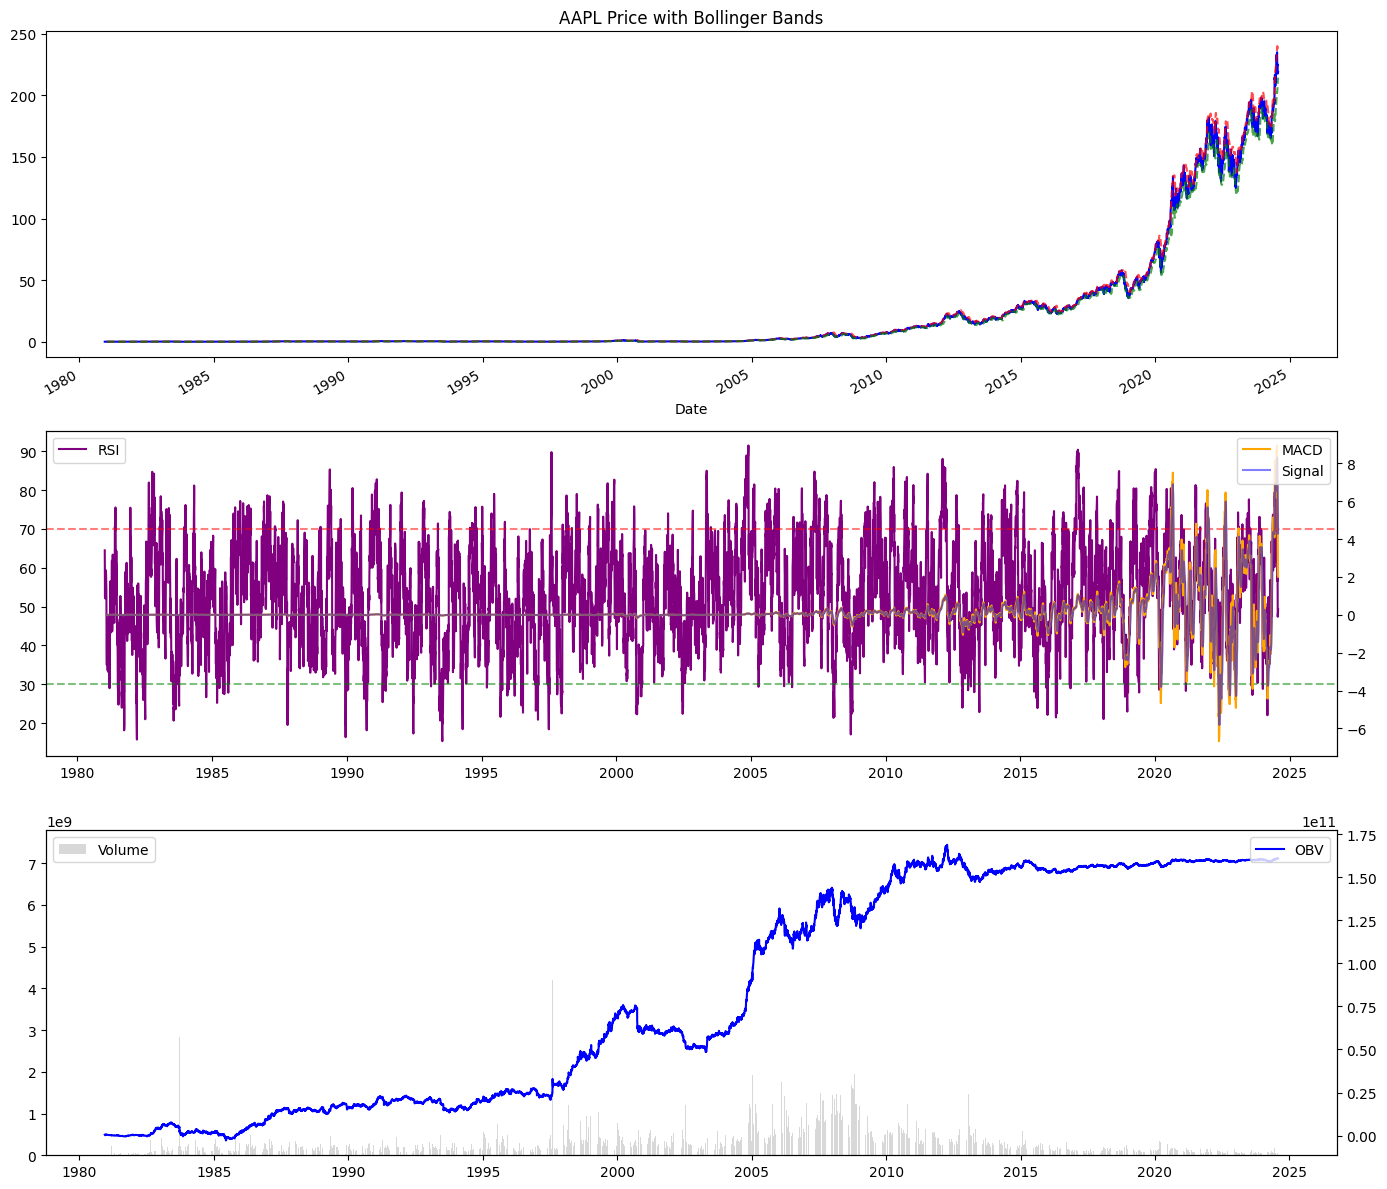

In [25]:
import matplotlib.pyplot as plt

def plot_stock_analysis(ticker, df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # Price + Bollinger Bands
    df['Close'].plot(ax=ax1, label='Close', color='blue')
    df['Bollinger_Upper'].plot(ax=ax1, ls='--', color='red', alpha=0.7)
    df['Bollinger_Lower'].plot(ax=ax1, ls='--', color='green', alpha=0.7)
    ax1.set_title(f'{ticker} Price with Bollinger Bands')
    
    # RSI + MACD
    ax2.plot(df['RSI_14'], label='RSI', color='purple')
    ax2.axhline(70, c='red', ls='--', alpha=0.5)
    ax2.axhline(30, c='green', ls='--', alpha=0.5)
    
    ax2b = ax2.twinx()
    ax2b.plot(df['MACD'], label='MACD', color='orange')
    ax2b.plot(df['MACD_Signal'], label='Signal', color='blue', alpha=0.5)
    ax2.legend(loc='upper left'); ax2b.legend(loc='upper right')
    
    # Volume + OBV
    ax3.bar(df.index, df['Volume'], color='gray', alpha=0.3, label='Volume')
    ax3b = ax3.twinx()
    ax3b.plot(df['OBV'], label='OBV', color='blue')
    ax3.legend(loc='upper left'); ax3b.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example for AAPL
plot_stock_analysis('AAPL', stocks['AAPL'])

#### Stock Analysis for Google (visualization)

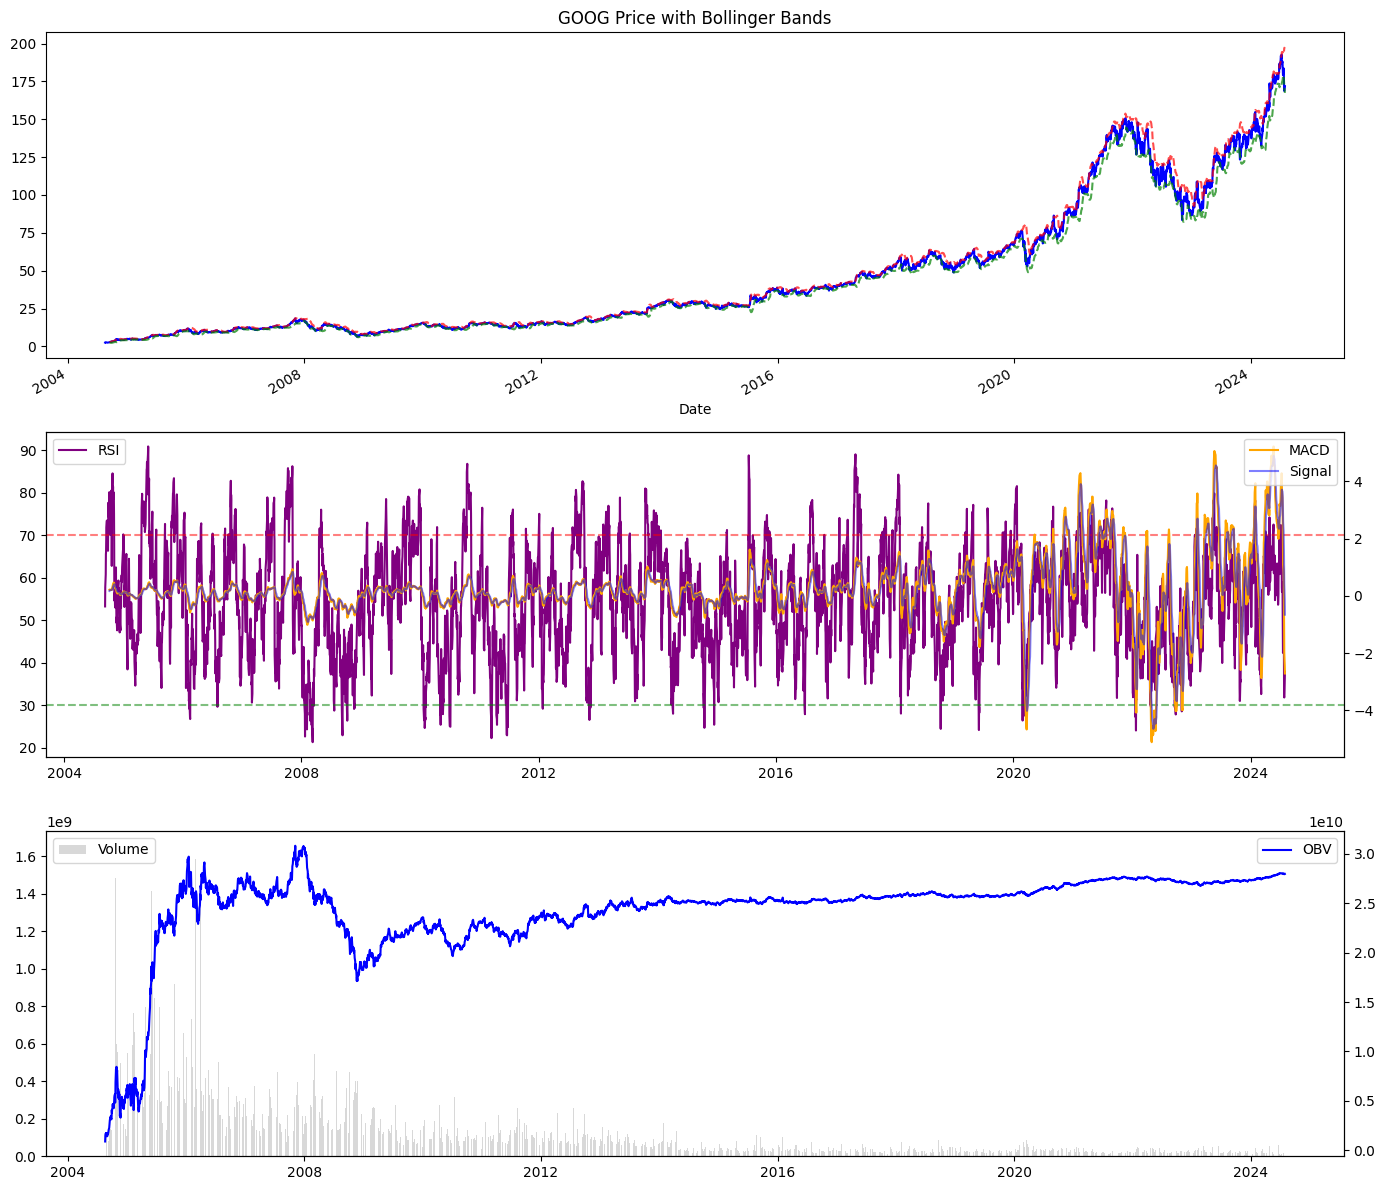

In [27]:
plot_stock_analysis('GOOG', stocks['GOOG'])

 #### Cross-Stock Compariso

C:\Users\user\AppData\Local\Temp\ipykernel_11956\1819345609.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  volatility = {ticker: df['Volatility_30D'][-1] for ticker, df in stocks.items()}


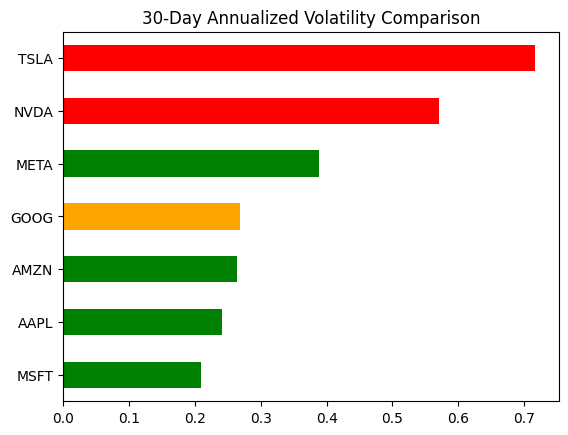

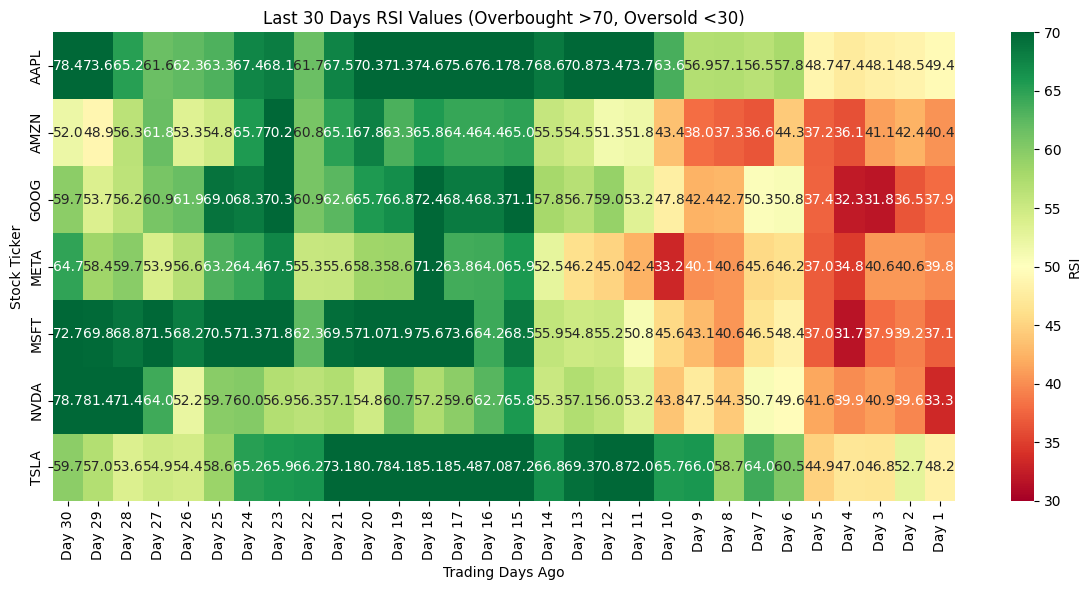

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # <-- Missing import added

# 1. Volatility Comparison (your working code)
volatility = {ticker: df['Volatility_30D'][-1] for ticker, df in stocks.items()}
pd.Series(volatility).sort_values().plot(
    kind='barh', 
    title='30-Day Annualized Volatility Comparison',
    color=[('red' if x > 0.4 else 'orange' if x > 0.3 else 'green') for x in volatility.values()]
)
plt.show()

# 2. RSI Heatmap (fixed)
date_labels = [f"Day {i}" for i in range(len(latest_rsi), 0, -1)]

plt.figure(figsize=(12, 6))
sns.heatmap(
    latest_rsi.T,
    cmap='RdYlGn',
    vmin=30,
    vmax=70,
    annot=True,
    fmt=".1f",
    xticklabels=date_labels,  # <-- Use custom labels
    cbar_kws={'label': 'RSI'}
)
plt.title('Last 30 Days RSI Values (Overbought >70, Oversold <30)')
plt.xlabel('Trading Days Ago')
plt.ylabel('Stock Ticker')
plt.tight_layout()
plt.show()